In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras

print(keras.__version__)

3.9.2


In [2]:
from keras.api.datasets import imdb
import os

unique_words = 10000
max_length = 100

output_dir = "tmp"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=unique_words)

In [3]:
from keras.api.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_length, padding="pre", truncating="pre", value=0)
X_valid = pad_sequences(X_valid, maxlen=max_length, padding="pre", truncating="pre", value=0)

In [4]:
from keras.api.models import Sequential
from keras.api.layers import InputLayer, Embedding, SpatialDropout1D, LSTM, Bidirectional, Dense

mlstm_model = Sequential()
mlstm_model.add(InputLayer(shape=(max_length,), dtype="float32"))
mlstm_model.add(Embedding(unique_words, 64))
mlstm_model.add(SpatialDropout1D(0.2))
mlstm_model.add(Bidirectional(LSTM(64, dropout=0.2, return_sequences=True)))
mlstm_model.add(Bidirectional(LSTM(64, dropout=0.2)))
mlstm_model.add(Dense(1, activation="sigmoid"))

mlstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,993 (3.07 MB)

 Trainable params: 804,993 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from keras.api.callbacks import ModelCheckpoint

mlstm_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

mlstm_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=4,
    validation_data=(X_valid, y_valid),
    callbacks=[ModelCheckpoint(filepath=output_dir + "/mlstm_weights.{epoch:02d}.keras")],
)

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - accuracy: 0.6880 - loss: 0.5421 - val_accuracy: 0.8267 - val_loss: 0.3947
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 416ms/step - accuracy: 0.8926 - loss: 0.2684 - val_accuracy: 0.8480 - val_loss: 0.3513
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 92s 472ms/step - accuracy: 0.9200 - loss: 0.2089 - val_accuracy: 0.8456 - val_loss: 0.3540
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 94s 478ms/step - accuracy: 0.9421 - loss: 0.1579 - val_accuracy: 0.8407 - val_loss: 0.4213


In [6]:
mlstm_model.load_weights(output_dir + "/mlstm_weights.02.keras")
mlstm_model.evaluate(X_valid, y_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.8468 - loss: 0.3551


[0.3513295352458954, 0.8479599952697754]

782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step


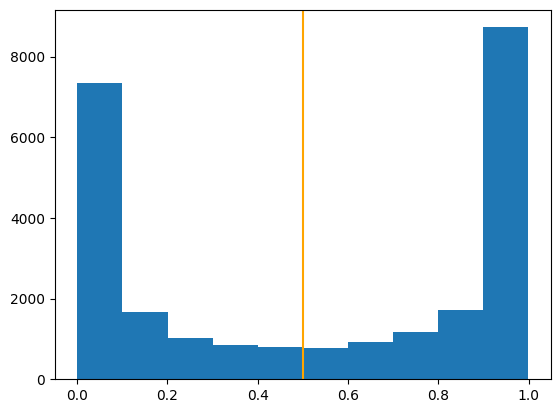

In [7]:
import matplotlib.pyplot as plt

plt.hist(mlstm_model.predict(X_valid))
_ = plt.axvline(x=0.5, color="orange")